# Preprocessing pipeline for Data

## 1. Read .mat file into numpy arrays

The data has the shape [64, 1500, 40, 6] (64 electrodes, 1500 data points and 40 trails in 60 blocks -> meaning 240 trials in total per subject)

In [1]:
#Packages
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import numpy as np
import mne
from mne_icalabel import label_components


#Constants

fs=250 # Sampling frequency

channel_names= [
  "FP1", "FPZ", "FP2", "AF3", "AF4",
  "F7", "F5", "F3", "F1", "FZ", "F2", "F4", "F6", "F8",
  "FT7", "FC5", "FC3", "FC1", "FCz", "FC2", "FC4", "FC6", "FT8",
  "T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", "T8",
  "M1", "TP7", "CP5", "CP3", "CP1", "CPZ", "CP2", "CP4", "CP6", "TP8",
  "M2", "P7", "P5", "P3", "P1", "PZ", "P2", "P4", "P6", "P8",
  "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8",
  "CB1", "O1", "Oz", "O2", "CB2"
]

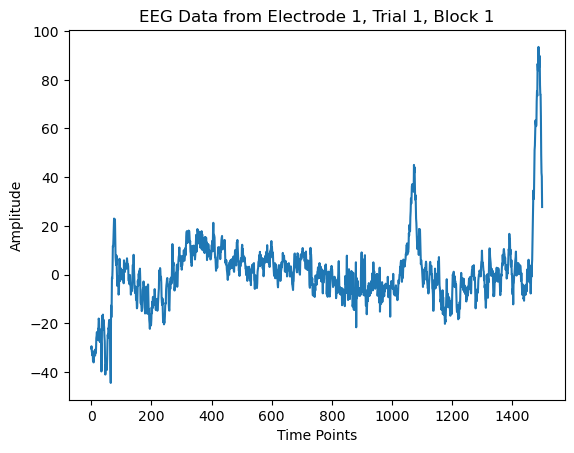

In [2]:
# Load the .mat file for one subject
data = loadmat("/Users/ankadilfer/Desktop/Master DTU/Semester 2/Introduction to Brain Computer Interfaces/Project Code/SSVEP-BCI-Data/S1.mat")


# Output the shape of the EEG data
eeg_data = data['data']  

#plot the EEG data from the first electrode, first trial, and first block
plt.plot(eeg_data[0, :, 0, 0])
plt.title('EEG Data from Electrode 1, Trial 1, Block 1')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.show()



## 2.Reshape data and create mne epoche object

In [3]:
# Reshape data 

X = np.transpose(eeg_data, (3, 2, 0, 1))   # (block, target, ch, time)
X = X.reshape(-1, 64, 1500)
print(X.shape)  # (trials, ch

n_blocks = 6
n_targets = 40

y = np.tile(np.arange(1, n_targets + 1), n_blocks)

events = np.zeros((240, 3), dtype=int)
events[:, 0] = np.arange(240)          # fake sample index
events[:, 2] = y                       # event id

event_id = {f"target_{i}": i for i in range(1, 41)}

info = mne.create_info(
    ch_names=channel_names,   # length = 64
    sfreq=250,                # Hz (downsampled)
    ch_types="eeg"
)


epochs = mne.EpochsArray(
    X,
    info,
    events=events,
    event_id=event_id,
    tmin=-0.5        # 500 ms pre-stimulus
)




(240, 64, 1500)
Not setting metadata


240 matching events found
No baseline correction applied
0 projection items activated


## 4. Set MNE montage

/var/folders/dc/h57683ts1p9901rkn9pm87zr0000gn/T/ipykernel_58114/544963559.py:3: RuntimeWarning: The unit for channel(s) CB1, CB2 has changed from V to NA.
  epochs.set_channel_types({


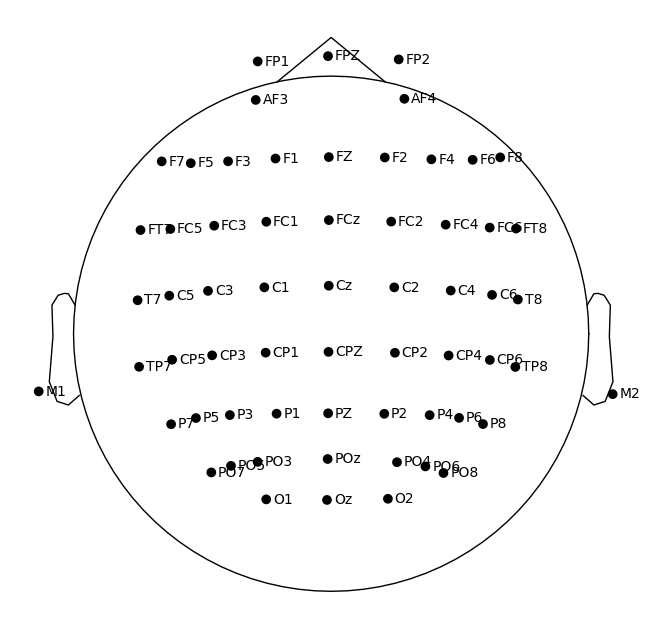

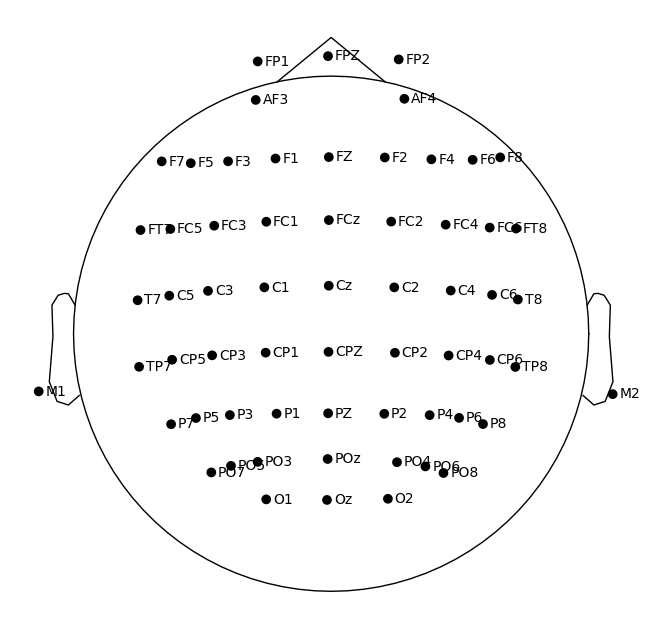

In [4]:

montage = mne.channels.make_standard_montage('standard_1020')

epochs.set_channel_types({
    'CB1': 'misc',
    'CB2': 'misc'
})

epochs.set_montage(montage, match_case=False)

epochs.plot_sensors(show_names=True)


# 5. Bandpass filtering

Setting up band-pass filter from 1 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 50.00 Hz: -6.02, -6.02 dB

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/Users/ankadilfer/anaconda3/envs/new_env_name/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


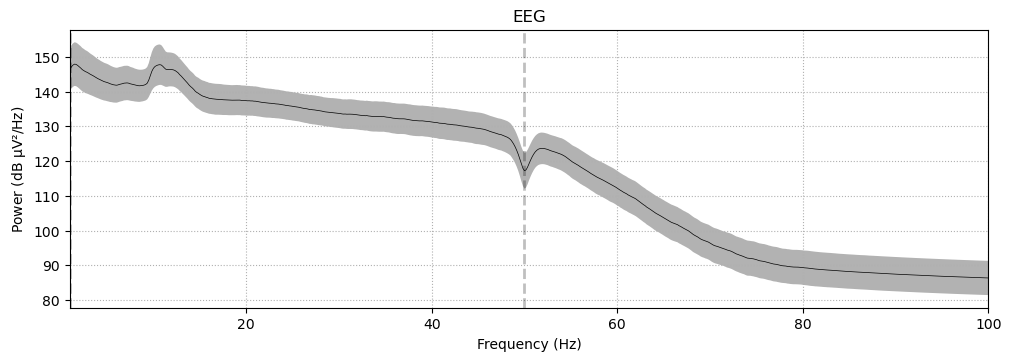

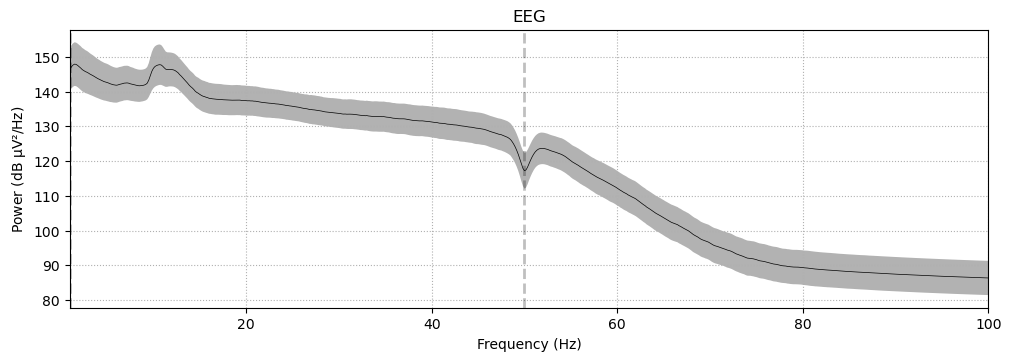

In [5]:
epochs.filter(
    l_freq=1,
    h_freq=50,
    method='iir'
)

epochs.compute_psd(fmin=1, fmax=100).plot(average=True, amplitude=False, picks="data", exclude="bads")

## 6. Remove bad channels and interpolate them

In [6]:
# Remove noisy channels

data = epochs.get_data(picks='eeg')  # shape: (n_epochs, n_ch, n_times)
variances = np.var(data, axis=(0, 2))

z = (variances - np.mean(variances)) / np.std(variances)

bad_idx = np.where(np.abs(z) > 5)[0]
bad_chs=[epochs.ch_names[i] for i in bad_idx]
print(bad_chs)

epochs.info['bads'].extend(bad_chs)
epochs.interpolate_bads(reset_bads=True)



[]
Setting channel interpolation method to {'eeg': 'spline'}.


/var/folders/dc/h57683ts1p9901rkn9pm87zr0000gn/T/ipykernel_58114/195670126.py:13: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads(reset_bads=True)


<EpochsArray | 240 events (all good), -0.5 – 5.496 s (baseline off), ~175.9 MB, data loaded,
 'target_1': 6
 'target_2': 6
 'target_3': 6
 'target_4': 6
 'target_5': 6
 'target_6': 6
 'target_7': 6
 'target_8': 6
 'target_9': 6
 'target_10': 6
 and 30 more events ...>

## 7. Rereference Signal

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


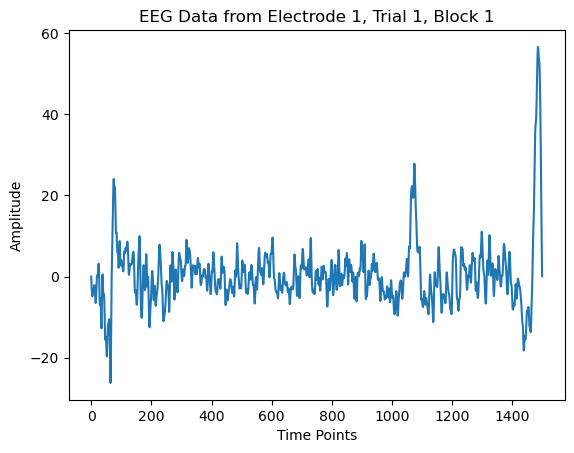

In [7]:
epochs.set_eeg_reference('average', projection=False)

eeg_data=epochs.get_data(picks='eeg')

plt.plot(eeg_data[0,0, :])
plt.title('EEG Data from Electrode 1, Trial 1, Block 1')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.show()


## 8. Remove artifacts with ICA

In [ ]:
ica = mne.preprocessing.ICA(
    n_components=0.9,
    random_state=42,
    method='infomax',
    fit_params=dict(extended=True),
    verbose=True
)
ica.fit(epochs)  
ica_labels = label_components(epochs, ica, method="iclabel")

ica.exclude =[
    i for i, label in enumerate(ica_labels['labels'])
    if label != 'brain'
]

cleaned_epochs = ica.apply(epochs.copy())


eeg_data=epochs.get_data(picks='eeg')

plt.plot(eeg_data[0,0, :])
plt.title('EEG Data from Electrode 1, Trial 1, Block 1')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.show()




Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by explained variance: 6 components
Computing Infomax ICA
Fitting ICA took 16.4s.


/var/folders/dc/h57683ts1p9901rkn9pm87zr0000gn/T/ipykernel_58114/1573036345.py:3: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(epochs, ica, method="iclabel")
/var/folders/dc/h57683ts1p9901rkn9pm87zr0000gn/T/ipykernel_58114/1573036345.py:3: RuntimeWarning: The provided ICA instance was fitted with a 'infomax' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ica_labels = label_components(epochs, ica, method="iclabel")
